In [95]:
import torch
from torch import nn # contains all of PyTorch's building blocks for NNs
import matplotlib.pyplot as plt
import numpy as np

# PyTorch Workflow: an example of a Pytorch end-to-end workflow

## 1. Data: prepare and load
Use a linear regression with known parameters to create new data

In [84]:
weight = 0.7
bias = 0.3

start = 0
end = 1
step = 0.02
X = torch.arange(start,end,step).unsqueeze(dim=1)

In [ ]:
X.shape

torch.Size([50, 1])

In [85]:
y = weight * X + bias

In [ ]:
X[:10], y[:10], len(X), len(y)

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]),
 50,
 50)

### Train and test sets

In [86]:
train_split = int(0.8 * len(X))
train_split
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]
len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

## 2. Create a Linear Regression model class

In [87]:
torch.randn((2,3)) # Returns a tensor filled with random numbers from a standard normal distribution

tensor([[-0.3204,  0.7377, -1.7534],
        [ 0.6033, -0.2520, -0.4373]])

In [88]:
class LinearRegressionModel(nn.Module): # Base class for all neural network modules.
  def __init__(self):
    super().__init__()
    # Parameter is Tensor subclass that, when assigned as attribute to a nn.Module instance, it's automatically added to its paramaters
    self.weights = nn.Parameter(torch.randn(1,
                                            requires_grad=True, # can this parameter be updated via gradient descent?
                                            # if True, PyTorch tracks the gradients of this parameter for use with torch.autograd (gradient descent)
                                            dtype = torch.float)) # assure that datatype is torch.float32, optimal for PyTorch
    self.bias = nn.Parameter(torch.randn(1,
                                         requires_grad = True,
                                         dtype = torch.float))

  # Forward method define the forward computation in the model, any child of nn.Module needs to override forward method
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.weights * x + self.bias

**What is a module?**
A module in PyTorch is basically a subclass of `nn.Module` acting like a container, which takes receives tensors as input and computes tensors as output.
The previous model, custom version of PyTorch’s Linear module, has the fundamental characteristics of a module:
1. inherits from the base Module class
2. define some "state" that is used in computation
3. define the "forward" function that performs the


### PyTorch model building essentials
* torch.nn
* torch.nn.Module
* torch.optim - contains several optimization algorithms to tell model parameters stored in nn.Parameter how to best change to improve gradient descent and reduce loss
* torch.utils.data.Dataset
* torch.utils.data.DataLoader

In [106]:
# Create a random seed to initialize weights
torch.manual_seed(101)

# Create an instance of the model
model = LinearRegressionModel()

# Check out the parameters
list(model.parameters())

[Parameter containing:
 tensor([-1.3905], requires_grad=True),
 Parameter containing:
 tensor([-0.8152], requires_grad=True)]

In [48]:
# List of each parameter with the corresponding attribute name
model.state_dict()

OrderedDict([('weights', tensor([-1.3905])), ('bias', tensor([-0.8152]))])

### Making prediction using `torch.inference_mode()`

In [49]:
y_pred = model(X_test)
y_pred

tensor([[-1.9276],
        [-1.9555],
        [-1.9833],
        [-2.0111],
        [-2.0389],
        [-2.0667],
        [-2.0945],
        [-2.1223],
        [-2.1501],
        [-2.1779]], grad_fn=<AddBackward0>)

Inference mode turns off gradient tracking and remove useless computations.
We could use also `with torch.no_grad(): ` but inference mode has some advantages over this


In [50]:
with torch.inference_mode():
  y_pred = model(X_test)
y_pred

tensor([[-1.9276],
        [-1.9555],
        [-1.9833],
        [-2.0111],
        [-2.0389],
        [-2.0667],
        [-2.0945],
        [-2.1223],
        [-2.1501],
        [-2.1779]])

### Train a model

In [107]:
# Setup a loss function
loss_fn = nn.L1Loss()

# Setup an optimizer
optimizer = torch.optim.SGD(params = model.parameters(),
                            lr = 0.1)

Steps of a Training Loop:
0. Loop through the data
1. Forward pass
2. Calculate the loss
3. Set the optimizer gradient to 0 - for every mini-batch during the training phase, we typically want to explicitly set the gradients to zero before starting to do backpropagation (i.e., updating the Weights and biases) because PyTorch accumulates the gradients on subsequent backward passes. This accumulating behavior is convenient while training RNNs or when we want to compute the gradient of the loss summed over multiple mini-batches
4. Backpropagation - compute the gradient of the loss wrt every model's parameter to be updates that is each parameter with `requires_grad = True`
5. Gradient descent - update the parameters with `requires_grad = True` wrt the loss gradient

Models have either one of these modes:
* Training mode - sets all parameteres taht require gradients to do so
* Evaluation mode - turns off gradient tracking

In [108]:
epochs = 100

# Track history
epoch_count = []
loss_values = []
test_loss_values = []

for epoch in range(epochs):
  # Set the model to training mode
  model.train()

  #1. Forward pass
  y_pred = model(X_train)
  # 2. Calculate the loss
  loss = loss_fn(y_pred, y_train)
  # 3. Optimizer zero grad
  optimizer.zero_grad()
  # 4. Backpropagation
  loss.backward()
  # 5.Update model parameters
  optimizer.step()

  # Testing, set off settings not needed for evaluation/testing (dropout, batch norm...)
  model.eval()
  with torch.inference_mode(): # Turns off gradient tracking
    test_pred = model(X_test)
    test_loss = loss_fn(test_pred, y_test)

  if epoch%10==0:
    epoch_count.append(epoch)
    loss_values.append(loss)
    test_loss_values.append(test_loss)

    print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")

Epoch: 0 | Loss: 1.9305353164672852 | Test loss: 2.841078281402588
Epoch: 10 | Loss: 0.7784351706504822 | Test loss: 1.4939781427383423
Epoch: 20 | Loss: 0.2763247787952423 | Test loss: 0.7125031352043152
Epoch: 30 | Loss: 0.23153117299079895 | Test loss: 0.5416391491889954
Epoch: 40 | Loss: 0.19701513648033142 | Test loss: 0.4520460069179535
Epoch: 50 | Loss: 0.16262713074684143 | Test loss: 0.36932194232940674
Epoch: 60 | Loss: 0.12833963334560394 | Test loss: 0.29346683621406555
Epoch: 70 | Loss: 0.09397915005683899 | Test loss: 0.2107427418231964
Epoch: 80 | Loss: 0.059604741632938385 | Test loss: 0.13488757610321045
Epoch: 90 | Loss: 0.02532033622264862 | Test loss: 0.05216345191001892


In [92]:
model.state_dict()

OrderedDict([('weights', tensor([-1.0005])), ('bias', tensor([0.1848]))])

In [110]:
with torch.inference_mode():
  y_pred = model(X_test)
y_pred

tensor([[0.9379],
        [0.9516],
        [0.9653],
        [0.9790],
        [0.9927],
        [1.0064],
        [1.0201],
        [1.0338],
        [1.0475],
        [1.0613]])

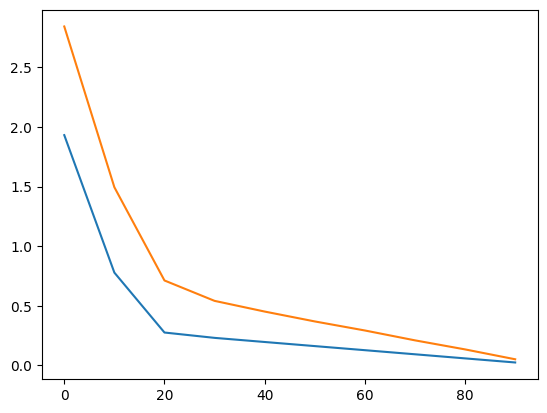

In [109]:
plt.plot(epoch_count, torch.tensor(loss_values).numpy(), label = 'Train loss')
plt.plot(epoch_count, test_loss_values, label = 'Test loss')

### Save a model in PyTorch
There are three main methods for saving&loading models in Pytorch:
1. `torch.save()` - save a PyTorch object in Python pickle format (used to save/load objects). It's better to save the model's `state_dict` instead of the whole model
2. `torch.load()` - load a saved PyTorch object
3. `torch.nn.Module.load_state_dict()` - load a model's saved state dictionary `state_dict()`

In [112]:
from pathlib import Path

#1. Create models directory
MODEL_PATH = Path('models')
MODEL_PATH.mkdir(parents=True, exist_ok=True)

#2. Create model save path
MODEL_NAME = 'dummy_model.pth' # Convention to save PyTorch models using ph or pth extension
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

MODEL_SAVE_PATH

#3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj = model.state_dict(),
           f = MODEL_SAVE_PATH)

Saving model to: models/dummy_model.pth


In [114]:
loaded_model = LinearRegressionModel() # Instantiated with random parameters
loaded_model.load_state_dict(torch.load(MODEL_SAVE_PATH))

<All keys matched successfully>

In [115]:
loaded_model.state_dict()

OrderedDict([('weights', tensor([0.6852])), ('bias', tensor([0.3898]))])

### Build a PyTorch Linear Model


In [120]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


In [117]:
class LinearRegressionModel2(nn.Module):
  def __init__(self):
    super().__init__()
    # torch.nn has pre-built computations like nn.Linear that creates the parameters for a linear regression model
    # Instead of defining the parameters, this is automatically handled based on the input and output shape
    self.linear_layer = nn.Linear(in_features = 1,
                                  out_features = 1)
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.linear_layer(x)

In [118]:
torch.manual_seed(101)
model = LinearRegressionModel2()
model, model.state_dict()

(LinearRegressionModel2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[-0.6039]])),
              ('linear_layer.bias', tensor([-0.0994]))]))

In [124]:
# Model's current device
print(next(model.parameters()).device)

# Move the model to GPU if available
model.to(device)
print(next(model.parameters()).device)

# Similarly the data since we need them on the same device
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

cpu
cpu


In [125]:
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params = model.parameters(), lr = 0.01)

In [126]:
torch.manual_seed(42)

# Set the number of epochs
epochs = 1000

for epoch in range(epochs):
  model.train()

  y_pred = model(X_train)
  loss = loss_fn(y_pred, y_train)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model.eval()

  with torch.inference_mode():
    test_pred = model(X_test)
    test_loss = loss_fn(test_pred, y_test)

  if epoch%100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")

Epoch: 0 | Loss: 0.9079464077949524 | Test loss: 1.5464258193969727
Epoch: 100 | Loss: 0.1947632133960724 | Test loss: 0.5341842174530029
Epoch: 200 | Loss: 0.14969071745872498 | Test loss: 0.3535514771938324
Epoch: 300 | Loss: 0.11526425927877426 | Test loss: 0.2687678039073944
Epoch: 400 | Loss: 0.08091464638710022 | Test loss: 0.18810442090034485
Epoch: 500 | Loss: 0.04657777398824692 | Test loss: 0.10812652111053467
Epoch: 600 | Loss: 0.01222942117601633 | Test loss: 0.028148645535111427
Epoch: 700 | Loss: 0.009021404199302197 | Test loss: 0.0051594078540802
Epoch: 800 | Loss: 0.009021404199302197 | Test loss: 0.0051594078540802
Epoch: 900 | Loss: 0.009021404199302197 | Test loss: 0.0051594078540802


In [127]:
print(model.state_dict())

OrderedDict([('linear_layer.weight', tensor([[0.6986]])), ('linear_layer.bias', tensor([0.3096]))])


In [128]:
model.eval()

with torch.inference_mode():
  y_pred = model(X_test)

y_pred

tensor([[0.8684],
        [0.8824],
        [0.8964],
        [0.9104],
        [0.9243],
        [0.9383],
        [0.9523],
        [0.9662],
        [0.9802],
        [0.9942]])

In [129]:
from pathlib import Path

MODEL_PATH = Path('models')
MODEL_PATH.mkdir(parents=True, exist_ok = True)

MODEL_NAME = 'model.pth'

MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f'Saving model to: {MODEL_SAVE_PATH}')
torch.save(obj = model.state_dict(), f = MODEL_SAVE_PATH)

Saving model to: models/model.pth
